<a href="https://colab.research.google.com/github/mehaase/w266-final-project/blob/main/FP_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/mnt/gdrive')
project_dir = "/mnt/gdrive/MyDrive/W266 Final Project"
train_df = pd.read_csv(f"{project_dir}/train_df.csv", index_col=0)
test_df = pd.read_csv(f"{project_dir}/test_df.csv", index_col=0)
train_df['is_hatespeech'] = train_df.is_hatespeech.astype(int)

Mounted at /mnt/gdrive


In [ ]:
!pip install transformers --quiet
from transformers import BertTokenizer, TFBertModel,TFAutoModel
from transformers import logging
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from transformers import TFAutoModel, AutoTokenizer


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 88.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.1 MB/s eta 0:00:00


# Using the Standard BERT Model

In [ ]:
# download the tokenizer and the BERT model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-cased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
MAX_SEQUENCE_LEN = 80

In [ ]:
train_inputs = bert_tokenizer(list(train_df.tweet),
                        max_length = MAX_SEQUENCE_LEN,
                        truncation = True,
                        padding = 'max_length',
                        return_tensors = 'tf')
train_labels = np.array(train_df.is_hatespeech.astype(int))
test_inputs = bert_tokenizer(list(test_df.tweet),
                        max_length = MAX_SEQUENCE_LEN,
                        truncation = True,
                        padding = 'max_length',
                        return_tensors = 'tf')
test_labels = np.array(test_df.is_hatespeech.astype(int))

In [ ]:
def create_bert_cls_model(max_sequence_length=MAX_SEQUENCE_LEN,
                          hidden_size = 100,
                          dropout=0.3,
                          learning_rate=0.000005):
    """
    Build a simple classification model with BERT. Use the CLS Token output for classification purposes.
    """

    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')
    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}
    bert_out = bert_model(bert_inputs)
    cls_token = bert_out[0][:, 0, :]
    hidden_1 = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer_1')(cls_token)
    #hidden_2 = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer_2')(hidden_1)
    hidden = tf.keras.layers.Dropout(dropout)(hidden_1)

    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                                 metrics='accuracy')

    return classification_model

In [ ]:
bert_classification_model = create_bert_cls_model()
bert_classification_model_history = bert_classification_model.fit(
    [train_inputs.input_ids, train_inputs.token_type_ids, train_inputs.attention_mask],
    train_labels,
    validation_data=([test_inputs.input_ids,test_inputs.token_type_ids, test_inputs.attention_mask], test_labels),
    batch_size=8,
    epochs=5
)

Epoch 1/5


286/286 [==============================] - 113s 241ms/step - loss: 0.6483 - accuracy: 0.6141 - val_loss: 0.4815 - val_accuracy: 0.7622
Epoch 2/5
286/286 [==============================] - 46s 160ms/step - loss: 0.4352 - accuracy: 0.8086 - val_loss: 0.4141 - val_accuracy: 0.8234
Epoch 3/5
286/286 [==============================] - 46s 160ms/step - loss: 0.3191 - accuracy: 0.8711 - val_loss: 0.4228 - val_accuracy: 0.8182
Epoch 4/5
286/286 [==============================] - 45s 158ms/step - loss: 0.2358 - accuracy: 0.9078 - val_loss: 0.4370 - val_accuracy: 0.8129
Epoch 5/5
286/286 [==============================] - 44s 155ms/step - loss: 0.1523 - accuracy: 0.9449 - val_loss: 0.5717 - val_accuracy: 0.8164


In [ ]:
bert_predictions = tf.math.round(bert_classification_model.predict([test_inputs.input_ids,test_inputs.token_type_ids, test_inputs.attention_mask]))

18/18 [==============================] - 7s 171ms/step


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
print(f'The precision of the model is {round(precision_score(test_labels, bert_predictions),4)}')
print(f'The recall of the model is {round(recall_score(test_labels, bert_predictions),4)}')
print(f'The f-1 score of the model is {round(f1_score(test_labels, bert_predictions),4)}')


The precision of the model is 0.8277
The recall of the model is 0.7893
The f-1 score of the model is 0.808


In [ ]:
def plot_train_test_loss(model_history):
    # Plot training/test loss against epochs
    ymax = max(np.max(model_history.history["loss"]), np.max(model_history.history["val_loss"]))
    plt.plot(model_history.history["loss"])
    plt.plot(model_history.history["val_loss"])
    plt.title("Train/Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.ylim(0.0, ymax * 1.1)
    plt.legend(["Train", "Test"])
    plt.show()

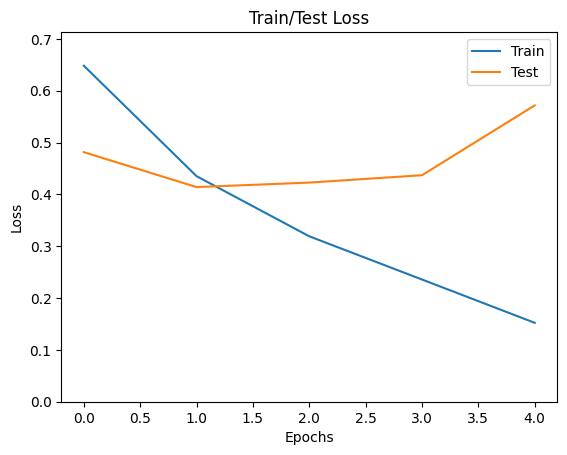

In [ ]:
plot_train_test_loss(bert_classification_model_history)

<Axes: >

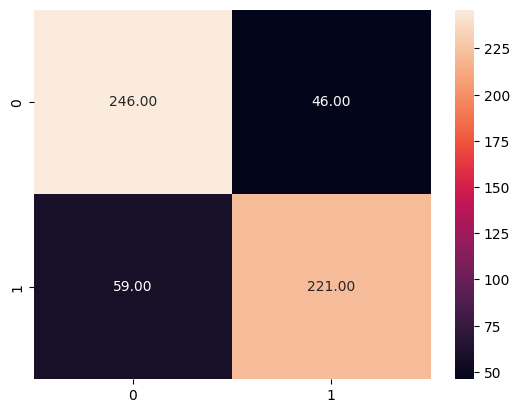

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.heatmap(confusion_matrix(test_labels, bert_predictions), annot = True, fmt = '.2f')

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Generate a sample correlation matrix (random data here)
# Replace this with your actual correlation matrix
np.random.seed(42)
correlation_matrix = np.random.rand(5, 5)

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Heatmap of the Correlation Matrix")
plt.show()


# BERTweet

In [ ]:
from transformers import TFAutoModel, AutoTokenizer

In [ ]:
bert_model_names = ['distilroberta-base',
                    'vinai/bertweet-base']

tokenizers = [AutoTokenizer.from_pretrained(bert_model_name)
              for bert_model_name in bert_model_names]
bert_models = [TFAutoModel.from_pretrained(bert_model_name)
               for bert_model_name in bert_model_names]
bert_last_layer_num = [5, 11]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [ ]:
BERTweet = TFAutoModel.from_pretrained('vinai/bertweet-base')

Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [ ]:
from transformers import AutoModel, AutoTokenizer
bertweet = AutoModel.from_pretrained("vinai/bertweet-base")
bertweet_tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False)

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# encoding the input data
BERTweet_max_len = 120
BERTweet_train_inputs = bertweet_tokenizer(list(train_df.tweet),
                        max_length = BERTweet_max_len,
                        truncation = True,
                        padding = 'max_length',
                        return_tensors = 'tf')
BERTweet_test_inputs = bertweet_tokenizer(list(test_df.tweet),
                        max_length = BERTweet_max_len,
                        truncation = True,
                        padding = 'max_length',
                        return_tensors = 'tf')
train_labels = np.array(train_df.is_hatespeech.astype(int))
test_labels = np.array(test_df.is_hatespeech.astype(int))

In [ ]:
def create_BERTweet_model(max_sequence_length=120,
                          hidden_size = 100,
                          dropout=0.3,
                          learning_rate=0.000005):
    """
    Build a simple classification model with BERT. Use the CLS Token output for classification purposes.
    """

    input_ids = tf.keras.layers.Input(shape=(max_sequence_length), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_masks = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')
    bert_out = BERTweet(input_ids, attention_mask = attention_masks, token_type_ids = token_type_ids)
    cls_token = bert_out[0][:, 0, :]
    hidden_1 = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer_1', activity_regularizer=tf.keras.regularizers.L2(0.01))(cls_token)
    hidden_2 = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer_2', activity_regularizer=tf.keras.regularizers.L2(0.01))(hidden_1)
    hidden = tf.keras.layers.Dropout(dropout)(hidden_2)

    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_masks], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                                 metrics='accuracy')

    return classification_model

In [ ]:
BERTweet_classification_model = create_BERTweet_model()
BERTweet_classification_model_history = BERTweet_classification_model.fit(
    [BERTweet_train_inputs.input_ids, BERTweet_train_inputs.token_type_ids, BERTweet_train_inputs.attention_mask],
    train_labels,
    validation_data=([BERTweet_test_inputs.input_ids,BERTweet_test_inputs.token_type_ids, BERTweet_test_inputs.attention_mask], test_labels),
    batch_size=4,
    epochs=5
)

Epoch 1/5


572/572 [==============================] - 96s 96ms/step - loss: 0.6929 - accuracy: 0.6119 - val_loss: 0.6133 - val_accuracy: 0.7552
Epoch 2/5
572/572 [==============================] - 25s 44ms/step - loss: 0.5618 - accuracy: 0.8195 - val_loss: 0.5196 - val_accuracy: 0.8409
Epoch 3/5
572/572 [==============================] - 25s 44ms/step - loss: 0.4753 - accuracy: 0.8816 - val_loss: 0.5028 - val_accuracy: 0.8304
Epoch 4/5
572/572 [==============================] - 24s 41ms/step - loss: 0.4220 - accuracy: 0.9143 - val_loss: 0.4862 - val_accuracy: 0.8374
Epoch 5/5
572/572 [==============================] - 24s 41ms/step - loss: 0.3754 - accuracy: 0.9414 - val_loss: 0.5901 - val_accuracy: 0.8042


In [ ]:
BERTweet_predictions = tf.math.round(BERTweet_classification_model.predict([BERTweet_test_inputs.input_ids,BERTweet_test_inputs.token_type_ids, BERTweet_test_inputs.attention_mask]))

18/18 [==============================] - 4s 38ms/step


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
print(f'The precision of the model is {round(precision_score(test_labels, BERTweet_predictions),4)}')
print(f'The recall of the model is {round(recall_score(test_labels, BERTweet_predictions),4)}')
print(f'The f-1 score of the model is {round(f1_score(test_labels, BERTweet_predictions),4)}')

The precision of the model is 0.7333
The recall of the model is 0.9429
The f-1 score of the model is 0.825


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

<Axes: title={'center': 'BERTweet Confusion Matrix'}, xlabel='Model Prediction', ylabel='True Label'>

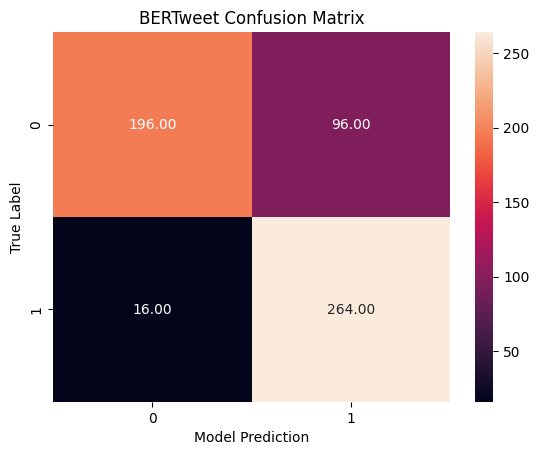

In [ ]:
BERTweet_matrix = sns.heatmap(confusion_matrix(test_labels, BERTweet_predictions), annot = True, fmt = '.2f')
plt.title("BERTweet Confusion Matrix")
plt.xlabel('Model Prediction')
plt.ylabel('True Label')
BERTweet_matrix

In [ ]:
labels = tf.reshape(BERTweet_predictions, (-1,))
labels.shape

TensorShape([572])

In [ ]:
test_df["predicted"] = labels.numpy().astype("bool")

In [ ]:
def show_tweet(idx):
    row = test_df.loc[idx]
    print(f"ground_truth={row.is_hatespeech} predicted={row.predicted}\n{row.tweet}")

## False negatives

In [ ]:
test_df[test_df.is_hatespeech & ~test_df.predicted]

,count,hate_speech,offensive_language,neither,class,tweet,is_hatespeech,predicted
1247,3,0.666667,0.333333,0.000000,0,AT_MENTION shut your legs hoe,True,False
1035,3,0.666667,0.333333,0.000000,0,A nicca say he ballin ask em where his title n...,True,False
2098,3,0.666667,0.333333,0.000000,0,Bumped into a bitch that filed for sexual hara...,True,False
2734,3,0.666667,0.333333,0.000000,0,RT AT_MENTION: You have a new boyfriend every ...,True,False
1907,3,1.000000,0.000000,0.000000,0,RT AT_MENTION: Beyonc&#233; is trash.,True,False
590,3,0.666667,0.333333,0.000000,0,Niggas/bitches cheat cause mf's always think t...,True,False
70,3,0.666667,0.333333,0.000000,0,RT AT_MENTION: Vin Scully once called me a cam...,True,False
683,3,0.666667,0.000000,0.333333,0,Karmas a bitch and so are you. You'll be getti...,True,False
2666,3,0.666667,0.000000,0.333333,0,RT AT_MENTION: AT_MENTION ching chong,True,False
1648,3,0.666667,0.333333,0.000000,0,"RT AT_MENTION: When niggas ask me ""Where the h...",True,False


In [ ]:
show_tweet(683)

ground_truth=True predicted=False
Karmas a bitch and so are you. You'll be getting along just fine real soon.


In [ ]:
show_tweet(1648)

ground_truth=True predicted=False
RT AT_MENTION: When niggas ask me "Where the hoes at?" http://t.co/eg6gxgGzFC


In [ ]:
show_tweet(2224)

ground_truth=True predicted=False
RT AT_MENTION: While the men will often be rambling and retarded, the women will appear trashy and tipsy, lawless and lustful http://t.co/A5&#8230;


In [ ]:
show_tweet(1175)

ground_truth=True predicted=False
I'm already tired and mr stupid af decides to show us a video on trigonometric notions so um yeah I just wanted to say you're a hoe


## False Positives

In [ ]:
test_df[~test_df.is_hatespeech & test_df.predicted].head(20)

,count,hate_speech,offensive_language,neither,class,tweet,is_hatespeech,predicted
1281,3,0.000000,1.000000,0.000000,1,"""For every bad bitch there is a nigga tired of...",False,True
1778,3,0.000000,0.000000,1.000000,2,AT_MENTION I heard green tea makes you lose we...,False,True
1075,3,0.000000,1.000000,0.000000,1,AT_MENTION AT_MENTION it was old ratchet hoes ...,False,True
112,3,0.333333,0.666667,0.000000,1,"Congratulations, your just like every other st...",False,True
64,3,0.333333,0.666667,0.000000,1,Did this bitch really just ask me do I have a ...,False,True
2323,3,0.000000,1.000000,0.000000,1,I'mma go with #6.\n\nCuz them Scream bitches S...,False,True
2147,3,0.000000,1.000000,0.000000,1,"AT_MENTION AT_MENTION oh, it's coming up, litt...",False,True
630,3,0.000000,1.000000,0.000000,1,RT AT_MENTION: Stole your grandpas wardrobe bi...,False,True
668,4,0.250000,0.750000,0.000000,1,trash both ways lol RT AT_MENTION: Bitch Kille...,False,True
1472,3,0.333333,0.666667,0.000000,1,AT_MENTION pussy,False,True


In [ ]:
show_tweet(302)

ground_truth=False predicted=True
Mitt Romney hates big bird. Fascist.


In [ ]:
show_tweet(2506)

ground_truth=False predicted=True
Why is AT_MENTION such a bitch? I mean who gets mild salsa? His father should be ashamed...


In [ ]:
show_tweet(2019)

ground_truth=False predicted=True
AT_MENTION lmaoooo I'm calling her a hoe and I'm mad? Shutcho uglass up


In [ ]:
show_tweet(880)

ground_truth=False predicted=True
AT_MENTION cause hes a faggot
